In [1]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import seaborn as sns
from scipy.spatial.distance import cdist
from utils.utils import *
from utils.ccf_utils import *
from scipy import stats, spatial
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
#plt.rcParams['font.family'] = 'Arial'

def readSWC(swc_path, mode='simple'):
    n_skip = 0
    with open(swc_path, "r") as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith("#"):
                n_skip += 1
            else:
                break
    names = ["##n", "type", "x", "y", "z", "r", "parent"]
    used_cols = [0, 1, 2, 3, 4, 5, 6]
    if mode == 'simple':
        pass
    df = pd.read_csv(swc_path, index_col=0, skiprows=n_skip, sep=" ",
                     usecols=used_cols,
                     names=names
                     )

    return df


import json
with open('../../data/region2primaryRegion.json', 'r') as f:
    region2primaryRegion = json.load(f)


def genObj(df, output_p):
    objLines = []
    NeuronHash = {}
    for k,i in enumerate(df.index):
        NeuronHash[i] = k
        line = 'v ' + str(df.loc[i,'x']) + ' ' + str(df.loc[i,'y']) + ' ' + str(df.loc[i,'z']) + '\n'
        objLines.append(line)
    for k,i in enumerate(df.index):
        p = df.loc[i,'parent']
        if p not in NeuronHash.keys():
            continue
        line = 'l ' + str(k + 1) + ' ' + str(NeuronHash[p] + 1) + '\n'
        objLines.append(line)

    with open(output_p, 'w') as f:
        f.writelines(objLines)

In [2]:
soma_feature = pd.read_csv('../../data/155k_DEN_soma_feature.csv', 
                           sep=',', index_col=0)
soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [3]:
len(soma_feature['source_region'].unique())

288

In [4]:
den_contact = pd.read_csv('../../data/ppss_from_pacs.csv', sep=',', index_col=0)

den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
0,0,6719.33,4732.66,4685.44,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
1,1,6719.74,4733.37,4685.04,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
2,2,6720.34,4733.72,4684.31,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
3,3,6720.94,4734.06,4683.59,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
4,4,6686.39,4743.11,4648.30,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,6,VAL,#acc2d9
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [5]:
den_contact.drop_duplicates(subset=['x', 'y', 'z'])

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
0,0,6719.33,4732.66,4685.44,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
1,1,6719.74,4733.37,4685.04,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
2,2,6720.34,4733.72,4684.31,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
3,3,6720.94,4734.06,4683.59,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,8,VAL,#acc2d9
4,4,6686.39,4743.11,4648.30,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_15287_15752_5070_CCFv3.swc,6,VAL,#acc2d9
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [6]:
len(list(den_contact['target_region'].unique()))

272

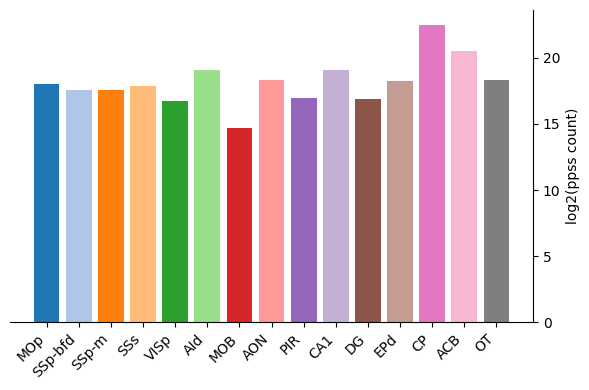

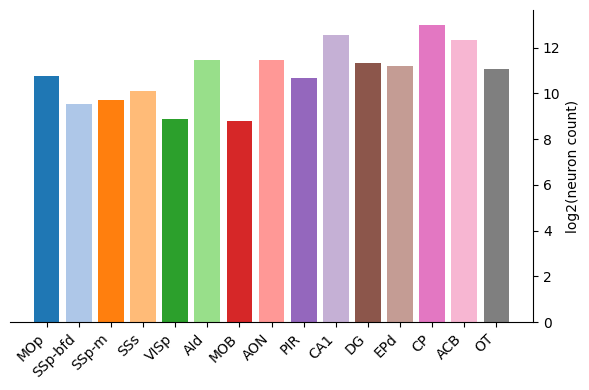

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

roi_list = ['MOp', 'SSp-bfd', 'SSp-m', 'SSs', 'VISp',
            'AId', 'MOB', 'AON', 'PIR', 'CA1',
            'DG', 'EPd', 'CP', 'ACB', 'OT']

df = den_contact
ppss_cnt = df['target_region'].value_counts().reindex(roi_list, fill_value=0)

neuron_cnt = (df.drop_duplicates(subset=['source_cell', 'target_region'])
                ['target_region'].value_counts()
                .reindex(roi_list, fill_value=0))

color_map = df.drop_duplicates('target_region').set_index('target_region')['color']

bar_colors = [color_map.get(r, '#999999') for r in roi_list]

log_ppss = ppss_cnt.apply(lambda x: 0 if x == 0 else np.log2(x))
log_neuron = neuron_cnt.apply(lambda x: 0 if x == 0 else np.log2(x))

plt.rcParams['figure.figsize'] = (6, 4)

plt.figure()
plt.bar(roi_list, log_ppss, color=bar_colors)
plt.ylabel('log2(ppss count)')
plt.xticks(rotation=45, ha='right')
ax = plt.gca() 
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('./ppss_num.svg', bbox_inches='tight')
plt.show()

plt.figure()
plt.bar(roi_list, log_neuron, color=bar_colors)
plt.ylabel('log2(neuron count)')
plt.xticks(rotation=45, ha='right')
ax = plt.gca() 
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('./neuron_num.svg', bbox_inches='tight')
plt.show()

In [8]:
soma_feature

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10001_19868_8155_CCFv3.swc,11287.600,3667.825,5563.125,fiber tracts,arb
SEU-ALLEN_local_15257_10008_10862_6996_CCFv3.swc,9625.025,3764.025,9017.726,ENTm,ENTm5
SEU-ALLEN_local_15257_10012_10978_7039_CCFv3.swc,9682.675,3754.125,8985.000,ENTm,ENTm5
SEU-ALLEN_local_15257_10020_17924_8129_CCFv3.swc,11267.750,3630.950,6364.775,fiber tracts,arb
SEU-ALLEN_local_15257_10028_28224_6732_CCFv3.swc,9298.925,3983.150,2374.200,SUB,SUB
...,...,...,...,...,...
SEU-ALLEN_local_236174_7626_18076_3068_CCFv3.swc,3998.550,1907.975,5585.175,ACAd,ACAd1
SEU-ALLEN_local_236174_8122_17844_3762_CCFv3.swc,4842.475,2017.425,5512.275,ACAd,ACAd2/3
SEU-ALLEN_local_236174_8813_17916_4826_CCFv3.swc,5990.175,2143.925,5498.300,ACAv,ACAv2/3


In [9]:
soma_feature[soma_feature["source_region"]=="unknow"]

,x,y,z,source_region,source_region_withCorticalRegion
swc_id,,,,,
SEU-ALLEN_local_15257_10131_17416_3416_CCFv3.swc,5387.675,4788.375,6327.925,unknow,unknow
SEU-ALLEN_local_15257_10263_23762_7075_CCFv3.swc,9717.100,3781.925,4079.600,unknow,unknow
SEU-ALLEN_local_15257_11265_28269_6943_CCFv3.swc,9502.525,3360.475,2320.775,unknow,unknow
SEU-ALLEN_local_15257_11420_23895_7324_CCFv3.swc,9970.350,3207.775,4023.100,unknow,unknow
SEU-ALLEN_local_15257_11977_22210_3467_CCFv3.swc,5372.225,3953.425,4774.850,unknow,unknow
...,...,...,...,...,...
SEU-ALLEN_local_211541_10856_8237_844_CCFv3.swc,155.300,4842.250,4248.225,unknow,unknow
SEU-ALLEN_local_211541_11841_5733_5707_CCFv3.swc,6791.075,6486.200,5049.925,unknow,unknow
SEU-ALLEN_local_211541_19623_4818_6314_CCFv3.swc,7165.500,6824.275,8527.275,unknow,unknow


In [39]:
ssp_list = ['SSp', 'SSp1', 'SSp2/3', 'SSp4', 'SSp5', 'SSp6a', 'SSp6b', 'SSp-n', 'SSp-n1', 'SSp-n2/3', 'SSp-n4', 'SSp-n5', 'SSp-n6a', 'SSp-n6b', 'SSp-bfd', 'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b', 'VISrll', 'VISrll1', 'VISrll2/3', 'VISrll4', 'VISrll5', 'VISrll6a', 'VISrll6b', 'SSp-ll', 'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b', 'SSp-m', 'SSp-m1', 'SSp-m2/3', 'SSp-m4', 'SSp-m5', 'SSp-m6a', 'SSp-m6b', 'SSp-ul', 'SSp-ul1', 'SSp-ul2/3', 'SSp-ul4', 'SSp-ul5', 'SSp-ul6a', 'SSp-ul6b', 'SSp-tr', 'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b', 'SSp-un', 'SSp-un1', 'SSp-un2/3', 'SSp-un4', 'SSp-un5', 'SSp-un6a', 'SSp-un6b']
visp_list = ['VISp', 'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b']

ssp_den_contact = den_contact[den_contact['target_region'].isin(ssp_list)].copy()

den_contact['source_region_withCorticalRegion'] = den_contact['target_cell'].map(soma_feature['source_region_withCorticalRegion'].to_dict())
visp_den_contact = den_contact[den_contact['source_region_withCorticalRegion'].isin(visp_list)].copy()

ca1_den_contact = den_contact[den_contact['target_region'].isin(['CA1'])].copy()

In [40]:
ca1_den_contact['count'] = 1

pt1 = ca1_den_contact.pivot_table(index='target_cell', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )
pt1.columns=[i[1] for i in pt1.columns]
pt1.to_csv('./ca1_cell_branch_level.csv')

In [41]:
ssp_den_contact['count'] = 1

pt1 = ssp_den_contact.pivot_table(index='target_cell', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )
pt1.columns=[i[1] for i in pt1.columns]
pt1.to_csv('./SSp_PACs_summary.csv')

In [42]:
visp_den_contact.loc[:, 'count'] = 1

wide_df2_ = visp_den_contact.pivot_table(index='source_region_withCorticalRegion', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )

wide_df2_.columns.name = ''
wide_df2_.columns = [i[1] for i in wide_df2_.columns]
wide_df2_.index.name = ''
wide_df2_.to_csv('./ppss_from_pac_visp_wide_df.csv')
wide_df2_

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
,,,,,,,,,,,,,,,,
VISp1,157,730,1436,2037,2392,2536,1945,1231,485,171,175,70,13,1,0,0
VISp2/3,793,2171,5068,6102,7851,6073,5062,3363,1543,915,482,140,134,9,0,0
VISp4,941,1643,2865,3580,4508,4590,3321,2148,1119,692,393,136,91,35,10,5
VISp5,773,2315,4066,4997,4532,3409,2455,1650,1014,488,136,108,29,15,0,0
VISp6a,148,512,1078,985,936,703,452,289,25,23,34,13,0,0,0,0
VISp6b,0,38,26,110,102,121,87,37,6,5,0,0,0,0,0,0


In [10]:
soma_feature = soma_feature[soma_feature['source_region'].isin(list(den_contact['target_region'].unique()))].copy()
soma_ct = soma_feature['source_region'].value_counts()
del soma_ct['fiber tracts']
# soma_ct = soma_ct[0:15]
soma_ct = soma_ct[soma_ct>=30]
soma_ct

source_region
CP     21802
MOB    16644
IC      6709
AN      4770
CUL     4444
       ...  
SNc       32
APN       32
FN        31
CA2       31
SMT       30
Name: count, Length: 175, dtype: int64

In [11]:
soma_ct['unknow']

np.int64(1654)

In [12]:
sele_region = region2primaryRegion.keys()
order_list = []

for i in sele_region:
    if i in list(soma_ct.index):
        order_list.append(i)

# print(len(order_list))

den_contact_tmp = den_contact[den_contact['target_region'].isin(order_list)].copy()

den_contact_tmp.loc[:, 'count'] = 1

wide_df2_ = den_contact_tmp.pivot_table(index='target_region', columns=['branch_level'], 
                                        values=['count'], aggfunc='sum', fill_value=0)

wide_df2_

count                                                         \
branch_level      1       2       3       4       5       6       7      8    
target_region                                                                 
AAA              144     673     853     823     829     399     335    121   
ACAd            3665   11133   22013   31999   32171   25411   19162  12339   
ACAv            3036    8519   15984   19129   19563   17962   13964   9883   
ACB            35287  113875  214127  286363  289798  236846  164850  94084   
AHN              367    1803    2026    2249    1289     603     282    192   
...              ...     ...     ...     ...     ...     ...     ...    ...   
VM              1266    4916   10949   18066   24360   25883   22083  17962   
VPL              445    2387    3129    2718    3789    3710    2792   2853   
VPM             1638    5430    6753    7372    8506    7042    6135   4801   
VTA              312    1022    1668    1716    1239    1001     501    182   
ZI               773    2324    4906    9538    9955   10205    7796   4704   

                             ...                                          
branch_level      9      10  ...    14   15   16   17  18 19 20 21 22 23  
target_region                ...                                          
AAA               55     26  ...     0    0    0    0   0  0  0  0  0  0  
ACAd            6836   4134  ...   142   29    0    0   0  0  0  0  0  0  
ACAv            5966   3474  ...   198   45   84   26  22  0  0  0  0  0  
ACB            49795  25866  ...  1258  329  165  126  14  0  0  0  0  0  
AHN                0      0  ...     0    0    0    0   0  0  0  0  0  0  
...              ...    ...  ...   ...  ...  ...  ...  .. .. .. .. .. ..  
VM             10437   5787  ...   136   99    9    0   0  0  0  0  0  0  
VPL             1707    856  ...    87    9    0    0   0  0  0  0  0  0  
VPM             3161   1427  ...    50   49    8    4   0  0  0  0  0  0  
VTA               40    117  ...     0    0    0    0   0  0  0  0  0  0  
ZI              3173   2058  ...   120    1    0    0   0  0  0  0  0  0  

[173 rows x 23 columns]

In [13]:
den_contact_tmp = den_contact[den_contact['target_region'].isin(order_list)].copy()
sample_df = (den_contact_tmp
             .groupby('target_region', group_keys=False)
             .apply(lambda g: g.sample(n=min(10000, len(g)), random_state=10))
             .loc[:, ['x', 'y', 'z', 'color', 'target_region']]
             .reset_index(drop=True))

sample_df.to_csv('./den_contact_test.csv')
sample_df

C:\Users\yishui\AppData\Local\Temp\ipykernel_66532\2451338905.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = (den_contact_tmp


,x,y,z,color,target_region
0,6137.28,6209.87,3531.19,#247afd,AAA
1,6150.36,6226.53,7951.93,#247afd,AAA
2,5874.26,6256.98,3245.52,#247afd,AAA
3,5557.66,6632.14,3368.82,#247afd,AAA
4,6023.94,6306.02,3278.78,#247afd,AAA
...,...,...,...,...,...
1219422,6563.68,5400.66,4517.94,#0a5f38,ZI
1219423,6484.62,5289.03,6857.86,#0a5f38,ZI
1219424,6502.79,5365.42,6588.39,#0a5f38,ZI
1219425,7421.41,4679.41,3785.51,#0a5f38,ZI


In [14]:
wide_df2_.columns.name = ''
wide_df2_.columns = [i[1] for i in wide_df2_.columns]
wide_df2_.index.name = ''

wide_df2_.to_csv("./ppss_from_pac_summary.csv")

In [15]:
wide_df2_

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AAA,144,673,853,823,829,399,335,121,55,26,...,0,0,0,0,0,0,0,0,0,0
ACAd,3665,11133,22013,31999,32171,25411,19162,12339,6836,4134,...,142,29,0,0,0,0,0,0,0,0
ACAv,3036,8519,15984,19129,19563,17962,13964,9883,5966,3474,...,198,45,84,26,22,0,0,0,0,0
ACB,35287,113875,214127,286363,289798,236846,164850,94084,49795,25866,...,1258,329,165,126,14,0,0,0,0,0
AHN,367,1803,2026,2249,1289,603,282,192,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM,1266,4916,10949,18066,24360,25883,22083,17962,10437,5787,...,136,99,9,0,0,0,0,0,0,0
VPL,445,2387,3129,2718,3789,3710,2792,2853,1707,856,...,87,9,0,0,0,0,0,0,0,0
VPM,1638,5430,6753,7372,8506,7042,6135,4801,3161,1427,...,50,49,8,4,0,0,0,0,0,0


In [16]:
# sele_region = region2primaryRegion.keys()
# order_list = []

# for i in sele_region:
#     if i in list(soma_ct.index):
#         order_list.append(i)

# print(len(order_list))

order_list = ['MOp', 'MOs', 'SSp-n', 'SSp-bfd', 'SSs', 'AUDp', 
              'VISp', 'CA1', 'DG', 'POST', 'CP', 'OT', 'MEA', 
              'GPe', 'BST', 'VPL', 'VPM', 'LGd', 'SNr', 'MRN',
              'PAG']

print(order_list)

['MOp', 'MOs', 'SSp-n', 'SSp-bfd', 'SSs', 'AUDp', 'VISp', 'CA1', 'DG', 'POST', 'CP', 'OT', 'MEA', 'GPe', 'BST', 'VPL', 'VPM', 'LGd', 'SNr', 'MRN', 'PAG']


## branch-level distribution in same source regions

In [17]:
den_contact = den_contact[den_contact['target_region'].isin(order_list)]
den_contact

,Unnamed: 0,x,y,z,source_cell,target_cell,branch_level,target_region,color
20,20,2963.27,2784.95,3914.27,15257_2226_x16029_y23953,SEU-ALLEN_local_182712_9293_13363_2479_CCFv3.swc,8,MOs,#56ae57
21,21,2810.66,2770.75,3799.39,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
22,22,2811.53,2770.50,3798.97,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
23,23,2812.41,2770.25,3798.56,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
24,24,2813.28,2770.00,3798.14,15257_2226_x16029_y23953,SEU-ALLEN_local_182722_11409_13793_2164_CCFv3.swc,9,MOs,#56ae57
...,...,...,...,...,...,...,...,...,...
17995300,22299324,3283.52,3644.60,8860.40,pre_18868_00465,SEU-ALLEN_local_201584_8835_21199_4542_CCFv3.swc,9,MOp,#1f77b4
17995301,22299325,3283.40,3647.35,8860.64,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995302,22299326,3283.27,3646.37,8860.83,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4
17995303,22299327,3283.14,3645.40,8861.01,pre_18868_00465,SEU-ALLEN_local_201584_8835_21214_4542_CCFv3.swc,7,MOp,#1f77b4


In [18]:
den_contact.loc[:, 'count'] = 1

wide_df2_ = den_contact.pivot_table(index='target_region', columns=['branch_level'], 
                        values=['count'], aggfunc='sum', fill_value=0
                       )

wide_df2_.columns.name = ''
wide_df2_.columns = [i[1] for i in wide_df2_.columns]
wide_df2_.index.name = ''
wide_df2_

C:\Users\yishui\AppData\Local\Temp\ipykernel_66532\2991686258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  den_contact.loc[:, 'count'] = 1


,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AUDp,683,2095,3687,5053,5237,5011,3572,2201,1342,871,...,3,6,0,19,0,0,0,0,0,0
BST,1085,2710,4718,4629,3831,2941,1630,1017,486,107,...,0,0,0,0,0,0,0,0,0,0
CA1,21833,59758,91175,117267,106796,74874,45241,27050,13222,6460,...,177,48,31,0,8,0,0,0,0,0
CP,152267,434873,763352,1013876,1050730,925271,680867,433581,239209,119925,...,4680,1812,737,189,38,0,0,0,0,0
DG,4908,16903,20712,24564,22048,14644,8516,4212,1736,740,...,27,0,0,0,0,0,0,0,0,0
GPe,424,1313,2540,3219,2762,2241,1195,782,446,312,...,9,0,0,0,0,0,0,0,0,0
LGd,268,427,609,942,1244,1224,1176,923,452,552,...,40,7,15,0,0,0,0,0,0,0
MEA,1299,3860,4686,4917,2765,1456,402,243,55,38,...,0,0,0,0,0,0,0,0,0,0
MOp,3543,14020,27732,38727,44214,41114,33858,23492,15175,9993,...,895,741,370,148,115,122,27,0,12,14


<Axes: ylabel='Count'>

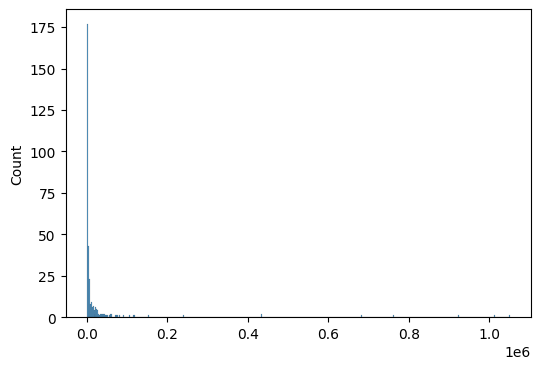

In [19]:
v = wide_df2_.values
v = v[v!=0]
sns.histplot(v)

In [20]:
wide_df2 = wide_df2_.copy()

for i in wide_df2.index:
   wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]

wide_df2

C:\Users\yishui\AppData\Local\Temp\ipykernel_66532\1929942465.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1178396072013093' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_66532\1929942465.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.4288052373158755' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wide_df2.loc[i, :] = wide_df2.loc[i, :] / soma_ct[i]
C:\Users\yishui\AppData\Local\Temp\ipykernel_66532\1929942465.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.0343698854337156' has dtype incompatible with int64, please explicitly cast to a co

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AUDp,1.117840,3.428805,6.034370,8.270049,8.571195,8.201309,5.846154,3.602291,2.196399,1.425532,...,0.004910,0.009820,0.000000,0.031097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BST,4.843750,12.098214,21.062500,20.665179,17.102679,13.129464,7.276786,4.540179,2.169643,0.477679,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CA1,9.906080,27.113430,41.367967,53.206443,48.455535,33.971869,20.526770,12.273140,5.999093,2.931034,...,0.080309,0.021779,0.014065,0.000000,0.003630,0.000000,0.000000,0.000000,0.000000,0.000000
CP,6.984084,19.946473,35.012935,46.503807,48.194202,42.439730,31.229566,19.887212,10.971883,5.500642,...,0.214659,0.083112,0.033804,0.008669,0.001743,0.000000,0.000000,0.000000,0.000000,0.000000
DG,2.264882,7.800185,9.557914,11.335487,10.174435,6.757730,3.929857,1.943701,0.801108,0.341486,...,0.012460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GPe,3.164179,9.798507,18.955224,24.022388,20.611940,16.723881,8.917910,5.835821,3.328358,2.328358,...,0.067164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LGd,0.701571,1.117801,1.594241,2.465969,3.256545,3.204188,3.078534,2.416230,1.183246,1.445026,...,0.104712,0.018325,0.039267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MEA,2.437148,7.242026,8.791745,9.225141,5.187617,2.731707,0.754221,0.455910,0.103189,0.071295,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MOp,1.762687,6.975124,13.797015,19.267164,21.997015,20.454726,16.844776,11.687562,7.549751,4.971642,...,0.445274,0.368657,0.184080,0.073632,0.057214,0.060697,0.013433,0.000000,0.005970,0.006965


In [21]:
wide_df2 = (wide_df2.T / wide_df2.sum(axis=1)).T
wide_df2

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
,,,,,,,,,,,,,,,,,,,,,
AUDp,0.022515,0.069060,0.121539,0.166568,0.172633,0.165183,0.117748,0.072554,0.044238,0.028712,...,0.000099,0.000198,0.000000,0.000626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BST,0.046749,0.116765,0.203283,0.199448,0.165065,0.126718,0.070231,0.043819,0.020940,0.004610,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CA1,0.038442,0.105218,0.160535,0.206476,0.188040,0.131833,0.079658,0.047628,0.023280,0.011374,...,0.000312,0.000085,0.000055,0.000000,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000
CP,0.025758,0.073566,0.129134,0.171514,0.177748,0.156525,0.115180,0.073347,0.040466,0.020287,...,0.000792,0.000307,0.000125,0.000032,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000
DG,0.041053,0.141386,0.173247,0.205467,0.184422,0.122491,0.071233,0.035232,0.014521,0.006190,...,0.000226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GPe,0.027529,0.085249,0.164914,0.208999,0.179327,0.145501,0.077587,0.050773,0.028957,0.020257,...,0.000584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LGd,0.030643,0.048822,0.069632,0.107706,0.142236,0.139950,0.134461,0.105534,0.051681,0.063115,...,0.004574,0.000800,0.001715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MEA,0.065862,0.195711,0.237591,0.249303,0.140192,0.073822,0.020382,0.012321,0.002789,0.001927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MOp,0.013420,0.053104,0.105042,0.146689,0.167472,0.155730,0.128246,0.088982,0.057479,0.037851,...,0.003390,0.002807,0.001401,0.000561,0.000436,0.000462,0.000102,0.000000,0.000045,0.000053


In [22]:
for i in range(1, max(wide_df2.columns)+1):
    if i not in list(wide_df2.columns):
        wide_df2[i] = 0

wide_df2 = wide_df2[list(range(1, 11))]
wide_df2

,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,
AUDp,0.022515,0.069060,0.121539,0.166568,0.172633,0.165183,0.117748,0.072554,0.044238,0.028712
BST,0.046749,0.116765,0.203283,0.199448,0.165065,0.126718,0.070231,0.043819,0.020940,0.004610
CA1,0.038442,0.105218,0.160535,0.206476,0.188040,0.131833,0.079658,0.047628,0.023280,0.011374
CP,0.025758,0.073566,0.129134,0.171514,0.177748,0.156525,0.115180,0.073347,0.040466,0.020287
DG,0.041053,0.141386,0.173247,0.205467,0.184422,0.122491,0.071233,0.035232,0.014521,0.006190
GPe,0.027529,0.085249,0.164914,0.208999,0.179327,0.145501,0.077587,0.050773,0.028957,0.020257
LGd,0.030643,0.048822,0.069632,0.107706,0.142236,0.139950,0.134461,0.105534,0.051681,0.063115
MEA,0.065862,0.195711,0.237591,0.249303,0.140192,0.073822,0.020382,0.012321,0.002789,0.001927
MOp,0.013420,0.053104,0.105042,0.146689,0.167472,0.155730,0.128246,0.088982,0.057479,0.037851


In [23]:
soma_ct[order_list]

source_region
MOp         2010
MOs         1508
SSp-n        776
SSp-bfd     1614
SSs         2948
AUDp         611
VISp        1817
CA1         2204
DG          2167
POST         340
CP         21802
OT          4161
MEA          533
GPe          134
BST          224
VPL          360
VPM          812
LGd          382
SNr          104
MRN          446
PAG          595
Name: count, dtype: int64

In [24]:
np.arange(0,len(wide_df2.columns)+1)+0.5

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5])

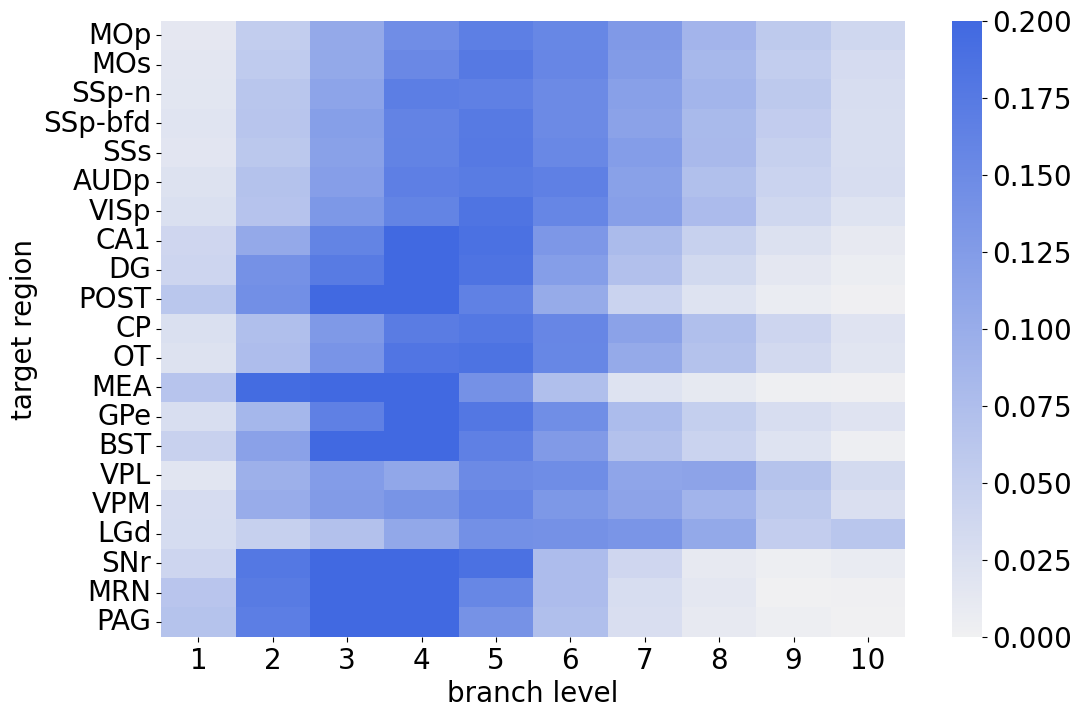

In [25]:
f,ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap((wide_df2.loc[order_list, :]), 
            vmin=0, vmax=0.2,
            cmap=sns.color_palette("light:royalblue", as_cmap=True),
            # vmax=0.3
           )
cb = ax.collections[0].colorbar
cb.ax.tick_params(labelsize=20)

ax.set_xlabel('branch level', fontsize=20)
ax.set_ylabel('target region', fontsize=20)

ax.set_xticks(np.arange(0,len(wide_df2.columns))+0.5, 
              list(range(1,len(wide_df2.columns)+1)), 
              fontsize=20)

ax.set_yticks(np.arange(0,len(order_list))+0.5, 
              order_list, fontsize=20, rotation=0)
plt.savefig('./ppss.svg', bbox_inches='tight')
plt.show()
